## Import packages

In [1]:
import ee

try:
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()
    
import geemap

import pandas as pd
from sklearn.cluster import DBSCAN
import numpy as np
import geopandas as gpd
from geeml.utils import eeprint
import matplotlib.pyplot as plt

In [2]:
Map = geemap.Map()
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

## Prepare data

In [3]:
# Risk of fires
fireRisk = ee.FeatureCollection("projects/ee-geethensingh/assets/postdoc/VeldFire_Risk_2010")
fireRisk = fireRisk.reduceToImage(properties = ['COUNT'], reducer = ee.Reducer.first()).rename('fireRisk')

In [4]:
Map.addLayer(fireRisk.randomVisualizer())

In [4]:
# Define start and end dates
startDate = ee.Date.fromYMD(2018, 7, 4)
endDate = ee.Date.fromYMD(2022, 8, 15)

# Create a list of years
years = ee.List.sequence(startDate.get('year'), endDate.get('year'))

# Filter countries by geometry
countries = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017")
geometry = ee.Geometry.Point([24.06353794842853, -29.732969740562062])
sa = countries.filterBounds(geometry)
sa_geo = sa.geometry()

# Define a function to remove fires with confidence level < 50%
def conf_mask(img):
    conf = img.select('ConfidenceLevel')
    level = conf.gt(50)
    return img.updateMask(level).select('BurnDate')
    
# Filter and map the fire collection
fire = ee.ImageCollection("ESA/CCI/FireCCI/5_1")
fire = fire \
    .filterBounds(sa_geo) \
    .filterDate(startDate, endDate) \
    .map(conf_mask)\
    .map(lambda img: img.addBands(ee.Image(ee.Image(img).date().get('year')).toInt().rename('BurnYear')))

# Set projection and scale
projection = fire.select('BurnDate').first().projection()

fire = fire.map(lambda image: image.setDefaultProjection(**{'crs':projection, 'scale': 250}))
fire

Name,Description
BurnDate,Estimated day of the year of the first detection of the burn
ConfidenceLevel,"Probability of detecting a pixel as burned, expressing the uncertainty of the detection for all pixels, even if they are classified as unburned."
LandCover,"Land cover category of the burned pixels, extracted from the CCI LandCover v2.0.7 product. See Defourny, P., Lamarche, C., Bontemps, S., De Maet, T., Van Bogaert, E., Moreau, I., Brockmann, C., Boettcher, M., Kirches, G., Wevers, J., Santoro, M., Ramoino, F., & Arino, O. (2017). Land Cover Climate Change Initiative - Product User Guide v2. Issue 2.0. [online] Available at: https://maps.elie.ucl.ac.be/CCI/viewer/download/ESACCI-LC-Ph2-PUGv2_2.0.pdf accessed: July 2020. © ESA Climate Change Initiative - Land Cover led by UCLouvain (2017)."
ObservedFlag,"Flags indicating why a pixel was not processed.-2: the pixel is not burnable (water bodies, bare areas, urban areas, permanent snow and ice)-1: the pixel has not been observed during the month (due to clouds, cloud shadows or sensor failure)"


In [ ]:
fire = ee.ImageCollection("MODIS/061/MCD64A1")
fire = fire \
    .filterBounds(sa_geo)

fire = fire.sort('system:time_start', False)
fire.first()

## Data Extraction

In [5]:
from geeml.extract import extractor
# For each pixel in the fire image collection (burn areas) extract coordinates, date and fire risk.

coords = ee.Image.pixelCoordinates('EPSG:4326')

# Initialise extractor
fire = fire.toList(fire.size())
for i in range(26, 27):
    inData = ee.ImageCollection(fire.slice(i, i+1)).first()
    inDate = inData.get('system:index').getInfo()
    fireExt = extractor(covariates = inData.addBands([fireRisk, coords]), target = inData,
                        aoi = sa_geo, scale = 250, dd= 'data', spcvGridSize= 30000)

    # Extract data in batches of 30 000 points
    fireExt.extractPoints(gridSize = 50000, batchSize = 30000, filename = f'fire_{inDate}.csv')


EEException: Image.rename: The number of names (1) must match the number of bands (2).

# Examine data

In [3]:
df = pd.read_csv(r'C:/Users/coach/Documents/scratch/Post_doc/Fire/data/fire_2019_08_01.csv')
df = df.dropna()
risk_dict = {7692: 'Extreme', 7805:'High', 2903:'Medium', 6555:'Low'}
df['risk'] = df['fireRisk'].astype(int).map(risk_dict)

# Combine 'year' and 'day_of_year' columns to create a new datetime column
df['date'] = pd.to_datetime(df['BurnYear'].astype(str) + df['BurnDate'].astype(str), format='%Y%j')

df.head()

,id,BurnDate,BurnYear,fireRisk,x,y,risk,date
0,30036.0,243,2019,7805.0,20.217709,-34.541344,High,2019-08-31
1,337737.0,228,2019,7692.0,24.972042,-33.753075,Extreme,2019-08-16
2,337737.0,228,2019,7692.0,24.974287,-33.753075,Extreme,2019-08-16
3,337737.0,228,2019,7692.0,24.976534,-33.753075,Extreme,2019-08-16
4,337737.0,228,2019,7692.0,24.969797,-33.750828,Extreme,2019-08-16


In [4]:
# https://stackoverflow.com/questions/34579213/dbscan-for-clustering-of-geographic-location-data
# https://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/
coords = df[['x', 'y']].values
db = DBSCAN(eps=2/6371., min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))

In [5]:
df['clusters'] = db.labels_
# df['clusters'].value_counts()

In [6]:
# Group by 'group' column and calculate the required values
grouped = df.groupby('clusters').agg(
    start_date=('date', 'min'),
    end_date=('date', 'max'),
    duration=('date', lambda x: (x.max() - x.min()).days + 1)
).reset_index()

# Merge the grouped data back into the original dataframe
result_df = df.merge(grouped, on='clusters')

result_df.head()

,id,BurnDate,BurnYear,fireRisk,x,y,risk,date,clusters,start_date,end_date,duration
0,30036.0,243,2019,7805.0,20.217709,-34.541344,High,2019-08-31,0,2019-08-31,2019-08-31,1
1,337737.0,228,2019,7692.0,24.972042,-33.753075,Extreme,2019-08-16,1,2019-08-16,2019-08-23,8
2,337737.0,228,2019,7692.0,24.974287,-33.753075,Extreme,2019-08-16,1,2019-08-16,2019-08-23,8
3,337737.0,228,2019,7692.0,24.976534,-33.753075,Extreme,2019-08-16,1,2019-08-16,2019-08-23,8
4,337737.0,228,2019,7692.0,24.969797,-33.750828,Extreme,2019-08-16,1,2019-08-16,2019-08-23,8


In [7]:
# Convert the DataFrame to a GeoDataFrame
geometry = gpd.points_from_xy(df['x'], df['y'])
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs = 'EPSG:4326')

# Plot the GeoDataFrame with colored points based on the 'color' column
# gdf.explore(column='clusters', legend=True)

# Show the plot
# plt.show()

In [8]:
# Load the harmonized Sentinel-2 image collection (surface reflectance)
collection = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 80))  # Optional cloud filtering

# Define a function to compute NBR
def compute_nbr(img):
    nbr = img.normalizedDifference(['B8', 'B12']).multiply(-1).rename('nbr')
    return nbr.set('system:time_start', img.get('system:time_start'))

# Map the NBR computation function over the collection
nbr_collection = collection.map(compute_nbr)

# Print the resulting image collection
eeprint(nbr_collection.limit(5))

In [9]:
# qualityMosaic for 95th percentile
# https://code.earthengine.google.com/c5199c1ab33b5bd6785e9f623c7cb4ad

# add evi band for each image
# add nbr band for each image
collection = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED").map(lambda img: 
    img.normalizedDifference(['B8', 'B4']).rename('ndvi').addBands([
    img.normalizedDifference(['B8', 'B12']).rename('nbr')]))

# Compute 95th percentile
nbrMaxNdvi = collection.qualityMosaic('ndvi')

def compute_dnbr(img):
    maxNBR = nbrMaxNdvi.select('nbr')
    return maxNBR.subtract(img.select('nbr')).rename('dnbr').set('system:time_start', img.get('system:time_start'))

dnbr_collection = nbr_collection.map(compute_dnbr)
dnbr_collection.limit(5)

Name,Description
B1,Aerosols
B2,Blue
B3,Green
B4,Red
B5,Red Edge 1
B6,Red Edge 2
B7,Red Edge 3
B8,NIR
B8A,Red Edge 4
B9,Water vapor


In [ ]:
for image get date
for each prior year
get a nbr scene closest to date of image
compute dnbr

In [12]:
def compute_mse(img):
    mse = img.pow(2).reduceRegion(
    reducer=ee.Reducer.mean(),  
    geometry=img.geometry(),      
    scale=10,
    maxPixels = 1e13)
    
    return ee.Image.constant(mse.get('dnbr'))
    
# # Define a function to compute the mean NBR within the ROI for each image
def compute_mse(img):
    # maxNBR = nbrMaxNdvi.select('nbr')
    meanNBR = (img).pow(2).reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=img.geometry(),
        scale=10, 
        maxPixels=1e13
    )
    return img.set('meanNBR', meanNBR)
mse_collection = dnbr_collection.limit(3).map(compute_mse)
mse_collection

### Plot Carbon monoxide (CO) or aerosol indexfor before and after fire event.

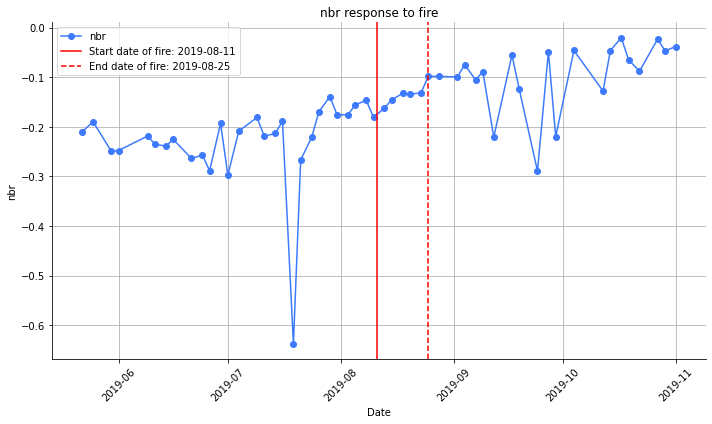

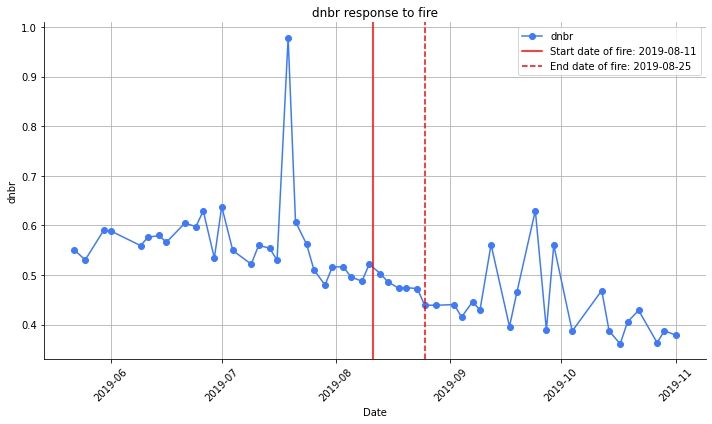

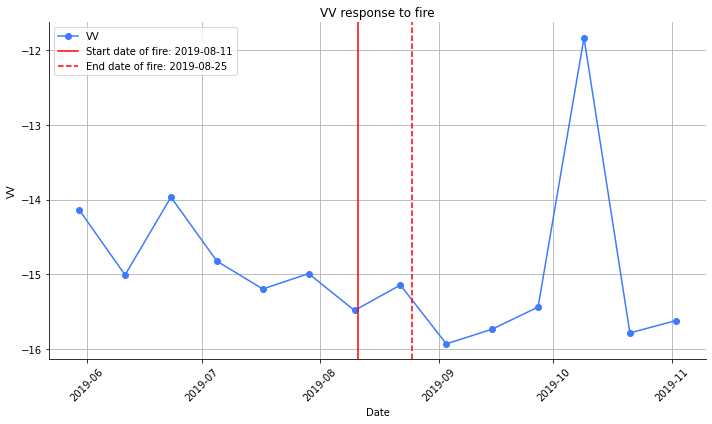

In [17]:
def plotTS(dataset, bandName, df, index, scale):
    """
    plot time series for aerosol index or carbon monoxide

    Args:
        dataset (ee.Imagecollection): Earth Engine imagecollection
        bandName (str):
        df (pd.DataFrame):
        index (int):
        scale (int): 

    Returns:
        plot
    """
    # Get row of data
    data = df.iloc[index,:]
    # format to pandas date
    # year = data['BurnYear']
    # day_of_year = data['BurnDate']
    # pdDate = pd.to_datetime(f'{year}-{day_of_year}', format='%Y-%j').date()
    pdDate = data['start_date'].date()
    date = ee.Date(str(pdDate))
    # For point extract data
    x = data['x']
    y = data['y']
    point = ee.Geometry.Point([x, y]).buffer(100)
    dataset = dataset.select(bandName).filterBounds(point).filterDate(date.advance(-12, 'week'), date.advance(12, 'week'))

    def poi_mean(img):
        mean = img.reduceRegion(reducer = ee.Reducer.mean(), geometry = point, scale = scale).get(bandName)
        return ee.Feature(None).set('date', img.date().format()).set('aai',mean)
    
    fc = dataset.map(poi_mean).filter(ee.Filter.notNull(['aai']))
    props = fc.first().propertyNames()
    output = fc.map(lambda ft: ft.set('output', props.map(lambda prop: ft.get(prop))))
    result = output.aggregate_array('output').getInfo()
    result = pd.DataFrame(result, columns= props.getInfo())
    result['date'] = pd.to_datetime(result['date']).dt.date

    plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
    plt.plot(result['date'], result['aai'], marker='o', linestyle='-', color= 'xkcd:lightish blue', label = bandName)
    plt.axvline(x=pdDate, color='red', linestyle='-', label= f'Start date of fire: {pdDate}')
    plt.axvline(x=data['end_date'], color='red', linestyle='--', label= f"End date of fire: {data['end_date'].date()}")
    plt.xlabel('Date')
    plt.ylabel(bandName)
    plt.title(f"{bandName} response to fire")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.gca().spines['top'].set_visible(False)# remove axis
    plt.gca().spines['right'].set_visible(False)
    plt.show()
    return result

aerosolIndex = ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_AER_AI")
CO = ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_CO")
DW = ee.ImageCollection("GOOGLE/DYNAMICWORLD/V1")
s1 = ee.ImageCollection("COPERNICUS/S1_GRD")

index = 100
# 18286
# result = plotTS(aerosolIndex, 'absorbing_aerosol_index', result_df, index, 1000)
# result = plotTS(CO, 'CO_column_number_density', result_df, index, 1000)
# result = plotTS(DW, 'trees', result_df, index, 10)
# result = plotTS(DW, 'grass', result_df, index, 10)
# result = plotTS(DW, 'shrub_and_scrub', result_df, index, 10)
result = plotTS(nbr_collection, 'nbr', result_df, index, 10)
result = plotTS(dnbr_collection, 'dnbr', result_df, index, 10)
result = plotTS(s1, 'VV', result_df, index, 10)


### Get animation of burn area for Sentinel-1 and Sentinel-2

In [11]:
# Get row of data
data = df.iloc[index,:]
# format to pandas date
year = data['BurnYear']
day_of_year = data['BurnDate']
pdDate = pd.to_datetime(f'{year}-{day_of_year}', format='%Y-%j').date()
date = ee.Date(str(pdDate))
# For point extract data
x = data['x']
y = data['y']
point = ee.Geometry.Point([x, y]).buffer(5000).bounds()
roi = point
if roi is None:
    roi = ee.Geometry.BBox(-74.7222, -8.5867, -74.1596, -8.2824)
    Map.addLayer(roi)
    Map.centerObject(roi)

In [15]:
timelapse = geemap.sentinel2_timelapse(
    roi,
    out_gif='sentinel2.gif',
    start_year= year,
    end_year= year,
    start_date='08-01',
    end_date='11-30',
    frequency='week',
    bands=['SWIR2','NIR', 'Red'],
    frames_per_second=1,
    title='Sentinel-2 Timelapse',
)
geemap.show_image(timelapse)

Generating URL...
Please wait ...
The GIF image has been saved to: c:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\notebooks\sentinel2.gif


Output()

In [13]:
pdDate

datetime.date(2019, 8, 16)

In [14]:
timelapse = geemap.sentinel1_timelapse(
    roi,
    out_gif='sentinel1.gif',
    start_year=2019,
    end_year=2019,
    start_date='08-01',
    end_date='11-01',
    bands=['VV'],
    frequency='day',
    vis_params={"min": -30, "max": 0},
    palette="Greys",
    frames_per_second=1,
    title='Sentinel-1 Timelapse',
    add_colorbar=True,
    colorbar_bg_color='gray',
)
geemap.show_image(timelapse)

Generating URL...
Please wait ...
The GIF image has been saved to: c:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\notebooks\sentinel1.gif


Output()

Outcomes: 
- CO > aerosol index. AI is too noisy, CO has a 2.5-5x difference during fire events
- VH > VV for visualising fire scars
- burn pixels to fire events - DBScan with haversine distance and radians on coordinates seems effective.
- positive samples (fires) take 1.5 hrs to extract for a month of modis fire
- negative samples (no fire) takes 30 mins to extract for a month of modis fire

Challenges+way forward
- CO signal might be influenced by surrounding fires. hard to say if other peaks are because of surrounding fires or other kinds of events.
- How to connect fires split between two different months- If data from months on either sides are combined

assign landsat or sentinel scene a p(fire) score
1. Binary classification - get probability of fire score - doesn't require downloading data.
2. For scenes that exceed fire probability score, map fire.

In [ ]:
kl divergence score
extract dnbr- 
    1) baseline image 
    2) closest image in previous years
    3) how many pixels exceed threshold (dnbr greater than previous steps)
    4) for cleaned time steps, fit linear model, if rate of change ratio between two consecutive images change rapidly (ratio greater than 2)
5) LC prior to scene
If error is bad, consider adding more types of data (weather, S1, fire risk index)